In [1]:
# Cell 1: Imports and Setup (Corrected for Notebook Path)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys

# --- Path Correction ---
# Get the current working directory and go one level up to the project root
# This ensures that the config paths work correctly from within the notebooks folder
print(f"Original working directory: {os.getcwd()}")
if os.getcwd().endswith('notebooks'):
    os.chdir('..')
print(f"New working directory: {os.getcwd()}")


# Add the src directory to the Python path
# This allows us to import our custom modules
module_path = os.path.abspath(os.path.join('.')) # Project root is now current dir
if module_path not in sys.path:
    sys.path.append(module_path)

from src import config

# Set some display options for pandas
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')

print("\nSetup Complete. Libraries imported and path configured.")
print(f"Raw data directory being used: {config.RAW_DATA_DIR}")

Original working directory: c:\Users\PC\EnergyOracle\notebooks
New working directory: c:\Users\PC\EnergyOracle

Setup Complete. Libraries imported and path configured.
Raw data directory being used: data/raw


In [2]:
# Cell 2: Load the Data
print("Loading data...")

try:
    train_df = pd.read_csv(config.TRAIN_FILE, parse_dates=['timestamp'])
    test_df = pd.read_csv(config.TEST_FILE, parse_dates=['timestamp'])
    metadata_df = pd.read_csv(config.METADATA_FILE)
    sample_submission_df = pd.read_csv(f"{config.RAW_DATA_DIR}/sample_submission.csv")

    print("Data loaded successfully!")
    print(f"Train data shape: {train_df.shape}")
    print(f"Test data shape: {test_df.shape}")
    print(f"Metadata shape: {metadata_df.shape}")

except FileNotFoundError as e:
    print(f"Error: {e}")
    print("Please make sure the data files are in the 'data/raw' directory.")

Loading data...
Data loaded successfully!
Train data shape: (2582976, 5)
Test data shape: (676800, 6)
Metadata shape: (94, 17)


In [3]:
# Cell 3: First Look at the Data

print("--- Train Data ---")
display(train_df.head())
print("\n--- Test Data ---")
display(test_df.head())
print("\n--- Metadata ---")
display(metadata_df.head())
print("\n--- Sample Submission ---")
display(sample_submission_df.head())

--- Train Data ---


,building_id,window_id,timestamp,meter_reading,role
0,H001,1,2018-07-01 00:00:00,1.4081,input
1,H001,1,2018-07-01 01:00:00,0.8785,input
2,H001,1,2018-07-01 02:00:00,0.4504,input
3,H001,1,2018-07-01 03:00:00,0.6049,input
4,H001,1,2018-07-01 04:00:00,0.2719,input



--- Test Data ---


,row_id,building_id,window_id,timestamp,meter_reading,role
0,1,H001,1,2019-07-09 00:00:00,0.6062,input
1,2,H001,1,2019-07-09 01:00:00,0.8477,input
2,3,H001,1,2019-07-09 02:00:00,0.3375,input
3,4,H001,1,2019-07-09 03:00:00,0.5490,input
4,5,H001,1,2019-07-09 04:00:00,0.3079,input



--- Metadata ---


,building_id,region,rooms,no_of_people,area_in_sqft,inverter,lights,ceiling_fans,air_coolers,air_conditioners,fridge,tv,water_heaters,washing_machine,mixer,iron,micro_wave
0,H001,Pune city,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1
1,H002,Pune city,5.0,4,1100.0,0.0,14,5,0,3.0,1,1,1,1,1,1,1
2,H003,Pune city,5.0,2,1000.0,0.0,16,6,0,0.0,1,1,3,1,1,1,1
3,H005,Pune city,4.0,5,NaN,0.0,4,3,0,1.0,1,0,0,0,0,1,1
4,H006,Pune city,3.0,4,530.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0



--- Sample Submission ---


,row_id,meter_reading
0,169,0
1,170,0
2,171,0
3,172,0
4,173,0


In [4]:
# Cell 4: Analyze Metadata
print("--- Metadata Info ---")
metadata_df.info()

print("\n--- Missing Values in Metadata ---")
missing_values = metadata_df.isnull().sum()
missing_percent = (missing_values / len(metadata_df) * 100).round(2)
missing_df = pd.DataFrame({'count': missing_values, 'percent': missing_percent})
print(missing_df[missing_df['count'] > 0])

--- Metadata Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   building_id       94 non-null     object 
 1   region            94 non-null     object 
 2   rooms             94 non-null     float64
 3   no_of_people      94 non-null     int64  
 4   area_in_sqft      83 non-null     float64
 5   inverter          90 non-null     float64
 6   lights            94 non-null     int64  
 7   ceiling_fans      94 non-null     int64  
 8   air_coolers       94 non-null     int64  
 9   air_conditioners  94 non-null     float64
 10  fridge            94 non-null     int64  
 11  tv                94 non-null     int64  
 12  water_heaters     94 non-null     int64  
 13  washing_machine   94 non-null     int64  
 14  mixer             94 non-null     int64  
 15  iron              94 non-null     int64  
 16  micro_wave        94 non

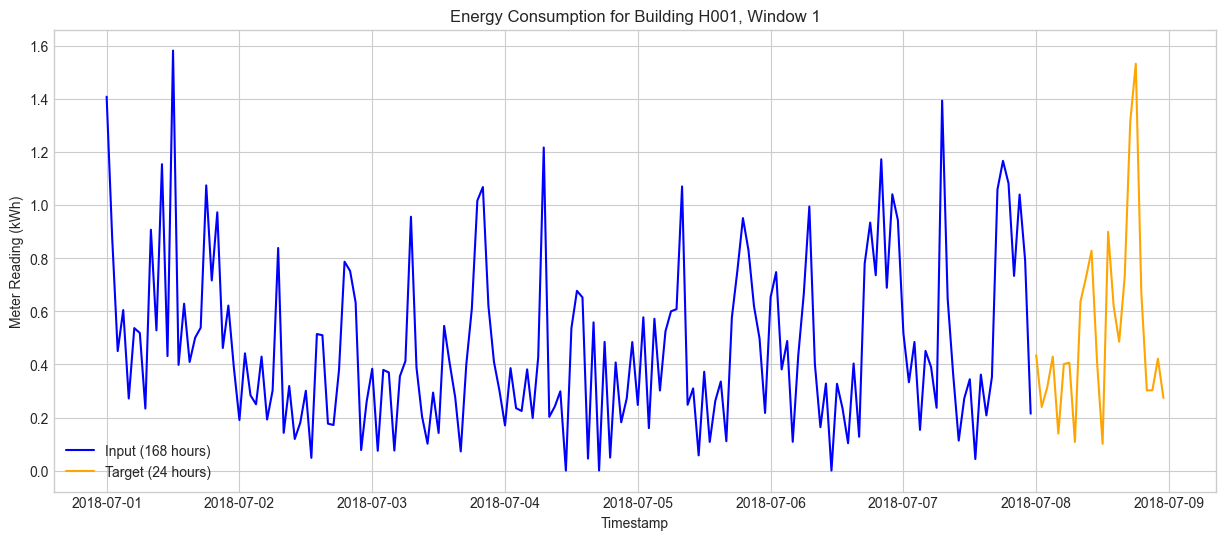

In [5]:
# Cell 5: Visualize a Building's Energy Consumption

# Filter for one building and one window
building_id_to_plot = 'H001'
window_id_to_plot = 1
sample_window_df = train_df[(train_df['building_id'] == building_id_to_plot) & (train_df['window_id'] == window_id_to_plot)]

# Separate input and target for plotting
input_df = sample_window_df[sample_window_df['role'] == 'input']
target_df = sample_window_df[sample_window_df['role'] == 'target']

plt.figure(figsize=(15, 6))
plt.plot(input_df['timestamp'], input_df['meter_reading'], label='Input (168 hours)', color='blue')
plt.plot(target_df['timestamp'], target_df['meter_reading'], label='Target (24 hours)', color='orange')

plt.title(f'Energy Consumption for Building {building_id_to_plot}, Window {window_id_to_plot}')
plt.xlabel('Timestamp')
plt.ylabel('Meter Reading (kWh)')
plt.legend()
plt.show()

In [ ]:
# Cell 6: Data Cleaning - Handling Missing Values (Future-Proof Version)

print("Handling missing values in metadata...")

# Impute area_in_sqft with the median
median_area = metadata_df['area_in_sqft'].median()
# --- Corrected line ---
metadata_df['area_in_sqft'] = metadata_df['area_in_sqft'].fillna(median_area)
print(f"Filled missing 'area_in_sqft' with median value: {median_area}")

# Impute inverter with the mode
mode_inverter = metadata_df['inverter'].mode()[0]
# --- Corrected line ---
metadata_df['inverter'] = metadata_df['inverter'].fillna(mode_inverter)
print(f"Filled missing 'inverter' with mode value: {mode_inverter}")


# Verify that there are no more missing values
print("\n--- Missing Values in Metadata After Cleaning ---")
print(f"Total missing values: {metadata_df.isnull().sum().sum()}")

Handling missing values in metadata...
Filled missing 'area_in_sqft' with median value: 750.0
Filled missing 'inverter' with mode value: 0.0

--- Missing Values in Metadata After Cleaning ---
Total missing values: 0


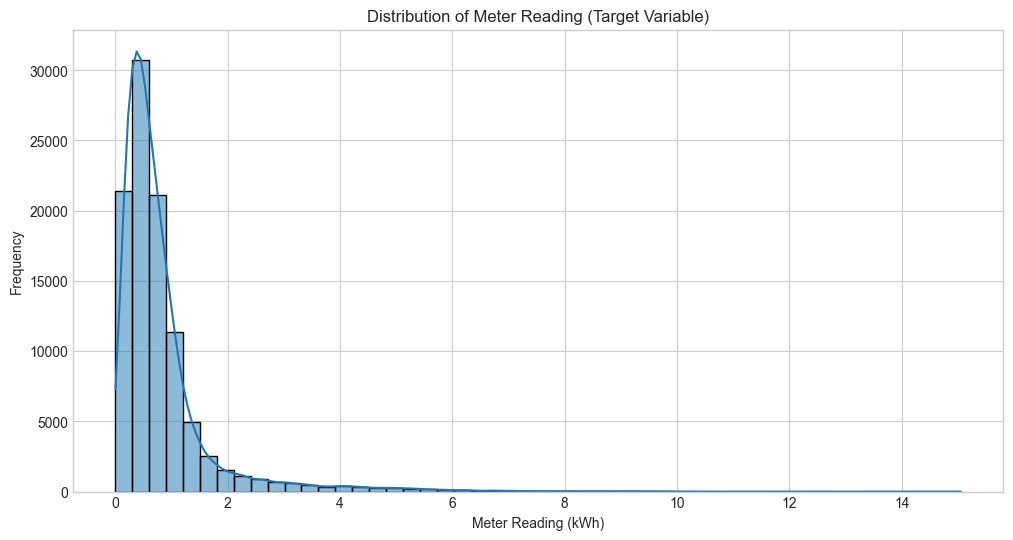

--- Descriptive Statistics for Meter Reading ---
count    2.582976e+06
mean     8.257981e-01
std      9.398431e-01
min      0.000000e+00
25%      3.337000e-01
50%      5.784000e-01
75%      9.425000e-01
max      2.013750e+01
Name: meter_reading, dtype: float64


In [7]:
# Cell 7: EDA - Distribution of the Target Variable (meter_reading)

plt.figure(figsize=(12, 6))
sns.histplot(train_df['meter_reading'].sample(100000), bins=50, kde=True)
plt.title('Distribution of Meter Reading (Target Variable)')
plt.xlabel('Meter Reading (kWh)')
plt.ylabel('Frequency')
plt.show()

print("--- Descriptive Statistics for Meter Reading ---")
print(train_df['meter_reading'].describe())

C:\Users\PC\AppData\Local\Temp\ipykernel_25932\2297161969.py:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='day_of_week', y='meter_reading', data=temp_train_df, ax=axes[1], order=days_order, palette='viridis')


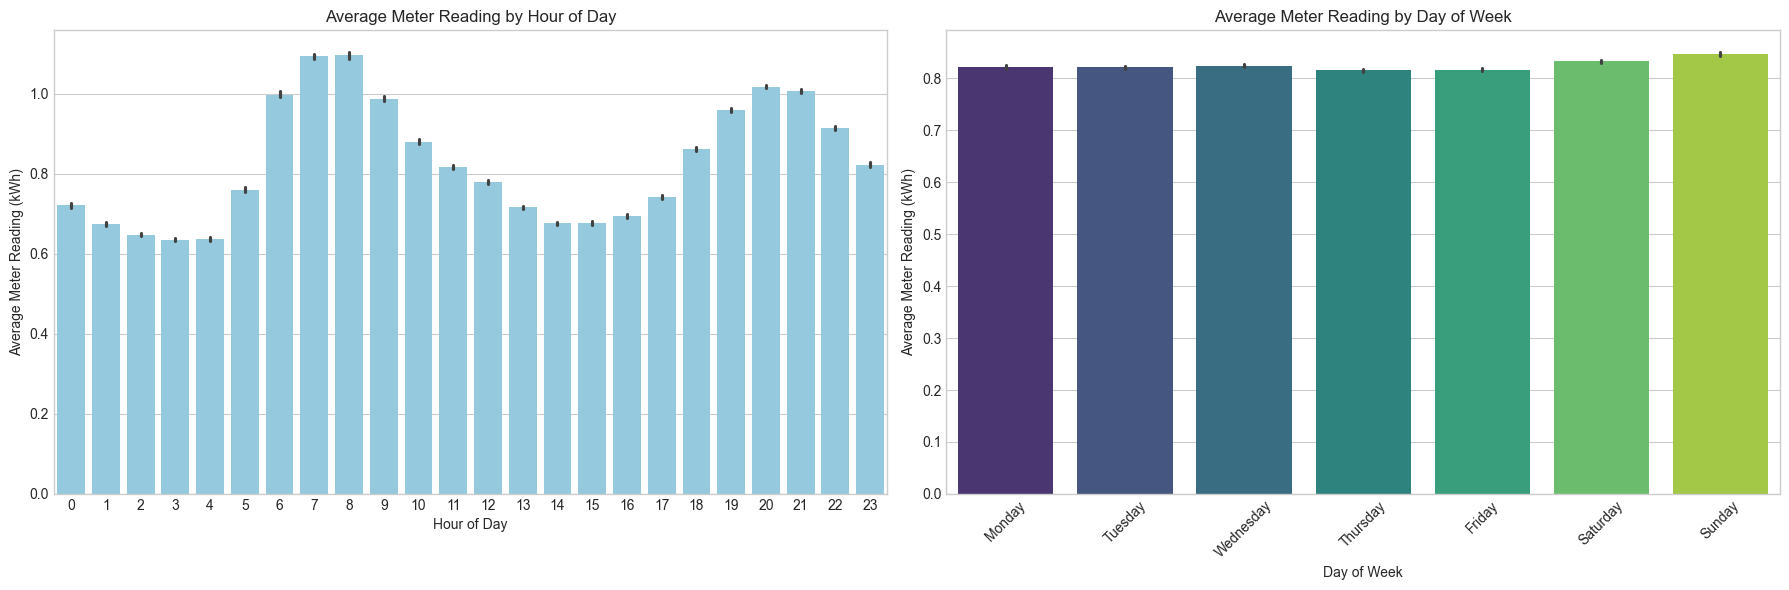

In [8]:
# Cell 8: EDA - Consumption Patterns by Time

# Create temporary time-based features for plotting
temp_train_df = train_df.copy()
temp_train_df['hour'] = temp_train_df['timestamp'].dt.hour
temp_train_df['day_of_week'] = temp_train_df['timestamp'].dt.day_name()
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Plot average consumption by hour
sns.barplot(x='hour', y='meter_reading', data=temp_train_df, ax=axes[0], color='skyblue')
axes[0].set_title('Average Meter Reading by Hour of Day')
axes[0].set_xlabel('Hour of Day')
axes[0].set_ylabel('Average Meter Reading (kWh)')

# Plot average consumption by day of week
sns.barplot(x='day_of_week', y='meter_reading', data=temp_train_df, ax=axes[1], order=days_order, palette='viridis')
axes[1].set_title('Average Meter Reading by Day of Week')
axes[1].set_xlabel('Day of Week')
axes[1].set_ylabel('Average Meter Reading (kWh)')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

In [9]:
# Cell 9: Import Feature Engineering Functions

from src.feature_engineering import (
    create_temporal_features,
    create_metadata_features
)

print("Feature engineering functions imported successfully.")

Feature engineering functions imported successfully.


In [10]:
# Cell 10: Apply Feature Engineering Pipeline

print("--- 1. Processing Metadata ---")
# The create_metadata_features function also handles the cleaning now
processed_metadata_df = create_metadata_features(metadata_df)
print("Metadata processed. New features created.")
display(processed_metadata_df.head())


print("\n--- 2. Merging DataFrames ---")
# Merge the processed metadata with the main train and test data
train_full_df = pd.merge(train_df, processed_metadata_df, on='building_id', how='left')
test_full_df = pd.merge(test_df, processed_metadata_df, on='building_id', how='left')
print("Merge complete.")
print(f"Train data shape after merge: {train_full_df.shape}")
print(f"Test data shape after merge: {test_full_df.shape}")


print("\n--- 3. Creating Temporal Features ---")
train_featured_df = create_temporal_features(train_full_df)
test_featured_df = create_temporal_features(test_full_df)
print("Temporal features created.")


print("\n--- Final Check: Displaying Featured Train Data ---")
display(train_featured_df.head())

--- 1. Processing Metadata ---
Metadata processed. New features created.


,building_id,rooms,no_of_people,area_in_sqft,inverter,lights,ceiling_fans,air_coolers,air_conditioners,fridge,tv,water_heaters,washing_machine,mixer,iron,micro_wave,occupancy_density,total_appliances,energy_intensity,region_Gonda,region_Kanpur rural,region_Pune,region_Pune city
0,H001,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1,0.004800,28.0,1.5,False,False,False,True
1,H002,5.0,4,1100.0,0.0,14,5,0,3.0,1,1,1,1,1,1,1,0.003636,29.0,12.5,False,False,False,True
2,H003,5.0,2,1000.0,0.0,16,6,0,0.0,1,1,3,1,1,1,1,0.002000,31.0,7.5,False,False,False,True
3,H005,4.0,5,750.0,0.0,4,3,0,1.0,1,0,0,0,0,1,1,0.006667,11.0,4.5,False,False,False,True
4,H006,3.0,4,530.0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0.007547,0.0,0.0,False,False,False,True



--- 2. Merging DataFrames ---
Merge complete.
Train data shape after merge: (2607936, 27)
Test data shape after merge: (701184, 28)

--- 3. Creating Temporal Features ---
Temporal features created.

--- Final Check: Displaying Featured Train Data ---


,building_id,window_id,timestamp,meter_reading,role,rooms,no_of_people,area_in_sqft,inverter,lights,ceiling_fans,air_coolers,air_conditioners,fridge,tv,water_heaters,washing_machine,mixer,iron,micro_wave,occupancy_density,total_appliances,energy_intensity,region_Gonda,region_Kanpur rural,region_Pune,region_Pune city,hour,day_of_week,day_of_month,month,is_weekend,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos
0,H001,1,2018-07-01 00:00:00,1.4081,input,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1,0.0048,28.0,1.5,False,False,False,True,0,6,1,7,1,0.000000,1.000000,-0.781831,0.62349
1,H001,1,2018-07-01 01:00:00,0.8785,input,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1,0.0048,28.0,1.5,False,False,False,True,1,6,1,7,1,0.258819,0.965926,-0.781831,0.62349
2,H001,1,2018-07-01 02:00:00,0.4504,input,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1,0.0048,28.0,1.5,False,False,False,True,2,6,1,7,1,0.500000,0.866025,-0.781831,0.62349
3,H001,1,2018-07-01 03:00:00,0.6049,input,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1,0.0048,28.0,1.5,False,False,False,True,3,6,1,7,1,0.707107,0.707107,-0.781831,0.62349
4,H001,1,2018-07-01 04:00:00,0.2719,input,3.0,3,625.0,0.0,19,3,0,0.0,1,1,0,1,1,1,1,0.0048,28.0,1.5,False,False,False,True,4,6,1,7,1,0.866025,0.500000,-0.781831,0.62349


In [19]:
# Cell 11 (V8 - Final, SIMPLIFIED, and Correct Architecture)

from sklearn.model_selection import train_test_split
import numpy as np

print("--- 1. Prepare Base DataFrames ---")
# Merge metadata onto the main dataframe first
train_full = pd.merge(train_df, processed_metadata_df, on='building_id', how='left')

# Separate the past (inputs) for feature creation
inputs = train_full[train_full['role'] == 'input'].copy().sort_values(by=['building_id', 'timestamp'])


print("--- 2. Create Context Features (Lags, Rolling, Aggs) ---")
# Lags
for lag in [24, 48, 168]:
    inputs[f'lag_{lag}'] = inputs.groupby('building_id')['meter_reading'].shift(lag)
# Rolling Windows
for window in [6, 12, 24]:
    rolling = inputs.groupby('building_id')['meter_reading'].rolling(window=window)
    inputs[f'rolling_mean_{window}'] = rolling.mean().reset_index(level=0, drop=True)
    inputs[f'rolling_std_{window}'] = rolling.std().reset_index(level=0, drop=True)
# Aggregations
agg_cols = {'meter_reading': ['mean', 'std', 'min', 'max']}
agg_features = inputs.groupby('window_id').agg(agg_cols)
agg_features.columns = ['_'.join(col).strip() for col in agg_features.columns.values]


print("--- 3. Create the Final Training DataFrame ---")
# Start with the target rows, which is what we want to predict
final_df = train_full[train_full['role'] == 'target'].copy()

# Add future time features TO THE TARGETS
final_df['target_hour'] = final_df['timestamp'].dt.hour
final_df['target_day_of_week'] = final_df['timestamp'].dt.dayofweek
final_df['target_hour_sin'] = np.sin(2 * np.pi * final_df['target_hour'] / 24)
final_df['target_hour_cos'] = np.cos(2 * np.pi * final_df['target_hour'] / 24)

# Get the most recent input row for each window to get recent features
recent_features = inputs.groupby('window_id').last()

# Define the columns we need from the recent features
recent_cols_to_merge = [col for col in recent_features.columns if 'lag' in col or 'rolling' in col]

# Merge all context features based on the window_id
# 1. Merge the aggregated stats
final_df = pd.merge(final_df, agg_features, on='window_id', how='left')
# 2. Merge the most recent lag/rolling stats
final_df = pd.merge(final_df, recent_features[recent_cols_to_merge], on='window_id', how='left')


print("--- 4. Finalize X and y ---")
# Define feature columns
features_to_drop = ['building_id', 'window_id', 'timestamp', 'meter_reading', 'role']
features = [col for col in final_df.columns if col not in features_to_drop]
target_col = 'meter_reading'

# Drop rows with NaNs created by lags/rolling windows AT THE VERY END
final_df.dropna(subset=features, inplace=True)

X = final_df[features]
y = final_df[target_col]

print(f"Final training data shape: X:{X.shape}, y:{y.shape}")

# Create validation split based on window_id
unique_windows = final_df['window_id'].unique()
train_windows, val_windows = train_test_split(unique_windows, test_size=0.2, shuffle=False)
train_idx = final_df['window_id'].isin(train_windows)
val_idx = final_df['window_id'].isin(val_windows)

X_train, y_train = X[train_idx], y[train_idx]
X_val, y_val = X[val_idx], y[val_idx]

print(f"Training data shape: X_train:{X_train.shape}, y_train:{y_train.shape}")
print(f"Validation data shape: X_val:{X_val.shape}, y_val:{y_val.shape}")

--- 1. Prepare Base DataFrames ---
--- 2. Create Context Features (Lags, Rolling, Aggs) ---
--- 3. Create the Final Training DataFrame ---
--- 4. Finalize X and y ---
Final training data shape: X:(325944, 39), y:(325944,)
Training data shape: X_train:(258240, 39), y_train:(258240,)
Validation data shape: X_val:(67704, 39), y_val:(67704,)


In [20]:
# Cell 12 (V5 - Single Model Training)

import xgboost as xgb
from sklearn.metrics import mean_squared_error

print("--- Training ONE powerful XGBoost model on the new data structure ---")

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000, # More estimators, let early stopping do its job
    learning_rate=0.05,
    max_depth=8, # A slightly deeper model may capture more interactions
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50 # Increase patience
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    verbose=100
)

print("\n--- Model Training Complete ---")

print("\n--- Evaluating Model ---")
val_preds = model.predict(X_val)
mse = mean_squared_error(y_val, val_preds)
rmse = np.sqrt(mse)

print(f"Validation MSE (Final Architecture): {mse:.4f}")
print(f"Validation RMSE (Final Architecture): {rmse:.4f}")

--- Training ONE powerful XGBoost model on the new data structure ---
[0]	validation_0-rmse:1.05805
[100]	validation_0-rmse:0.85679
[166]	validation_0-rmse:0.85793

--- Model Training Complete ---

--- Evaluating Model ---
Validation MSE (Final Architecture): 0.7330
Validation RMSE (Final Architecture): 0.8561


In [13]:
# Cell 13: Feature Importance Plot

# plt.figure(figsize=(10, 10))
# xgb.plot_importance(multi_output_model.estimators_[0], max_num_features=30, height=0.8) # Example for the first model
# plt.title('Feature Importance for Target Hour 0')
# plt.show()

In [21]:
# Cell 12 (V6 - Final Breakthrough Version)

import xgboost as xgb
from sklearn.metrics import mean_squared_error
import numpy as np

print("--- Training with a SIMPLER model and LOG-TRANSFORMED target ---")

# --- ADD THIS: Log transform the target variable ---
y_train_log = np.log1p(y_train)
y_val_log = np.log1p(y_val)

model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=1000,
    learning_rate=0.05,
    max_depth=5, # Keep the simpler model
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    early_stopping_rounds=50
)

# --- IMPORTANT: Train on the log-transformed y ---
model.fit(
    X_train, y_train_log,
    eval_set=[(X_val, y_val_log)],
    verbose=100
)

print("\n--- Model Training Complete ---")

print("\n--- Evaluating Model ---")
# Predict on the validation set (predictions will be in log scale)
val_preds_log = model.predict(X_val)

# --- ADD THIS: Inverse transform the predictions back to the original scale ---
val_preds = np.expm1(val_preds_log)

# --- IMPORTANT: Calculate MSE on the original scale y_val ---
mse = mean_squared_error(y_val, val_preds)
rmse = np.sqrt(mse)

print(f"Validation MSE (Final Architecture): {mse:.4f}")
print(f"Validation RMSE (Final Architecture): {rmse:.4f}")

--- Training with a SIMPLER model and LOG-TRANSFORMED target ---
[0]	validation_0-rmse:0.38834
[100]	validation_0-rmse:0.29158
[144]	validation_0-rmse:0.29184

--- Model Training Complete ---

--- Evaluating Model ---
Validation MSE (Final Architecture): 0.7784
Validation RMSE (Final Architecture): 0.8823
